In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta


# Without context

In [37]:
class Bandit:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.means = np.random.uniform(0, 1, num_arms)
        
    def push(self):
        return np.random.uniform(0, 1, self.num_arms) < self.means

In [38]:
def test(agent, num_arms=10, n_steps=1000):
    selected_arm = np.zeros(n_steps)
    acc = 0
    regret = 0
    regret_arr = np.zeros(n_steps)

    bandit = Bandit(num_arms)
    optimal_arm = np.argmax(bandit.means)

    for step in range(n_steps):
        arm = agent.action(step + 1)
        reward = bandit.push()
        agent.step(arm, reward)

        selected_arm[step] = arm
        if bandit.push()[arm]:
            acc += 1
        else:
            regret += 1

        regret_arr[step] = regret


    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.title("Selected arm")
    plt.scatter(range(n_steps), selected_arm, s=2)
    plt.yticks(np.arange(0, num_arms, 1))
    plt.grid(True, which='both')

    plt.subplot(1, 2, 2)
    plt.title("Accumulated regret")
    plt.ylim(0, n_steps)
    plt.plot(regret_arr)
    plt.grid(True, which='both')

    plt.tight_layout()
    plt.show()

    print("Истинные средние:", np.round(bandit.means, 2))
    print("Найденные оценки:", np.round(agent.Q, 2))
    print("Accyracy:", acc / n_steps)
    print("Оптимальная рука:", optimal_arm)


## e-greedy

In [39]:
class EGreedy:
    def __init__(self, num_arms, epsilon=0.1):
        self.num_arms = num_arms
        self.init_epsilon = epsilon
        self.cur_epsilon = epsilon
        # self.Q = np.zeros(num_arms)
        self.Q = np.array([0.5] * num_arms)
        self.N = np.zeros(num_arms)
    
    def action(self, step):
        self.cur_epsilon = np.exp(-step / 70)

        if np.random.uniform(0, 1) < self.cur_epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.Q)
        
    
    def step(self, arm, reward):
        self.N[arm] += 1
        self.Q[arm] = self.Q[arm] + (reward[arm] - self.Q[arm]) / self.N[arm]

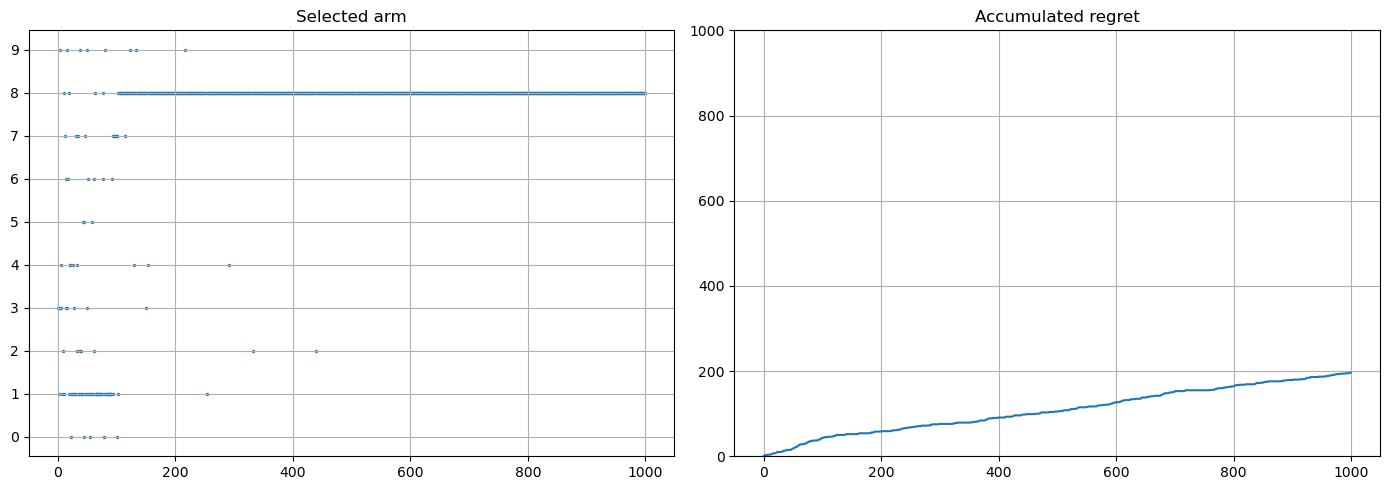

Истинные средние: [0.42 0.69 0.32 0.51 0.83 0.36 0.07 0.67 0.86 0.23]
Найденные оценки: [0.4  0.73 0.29 0.56 0.5  0.33 0.17 0.67 0.87 0.38]
Accyracy: 0.804
Оптимальная рука: 8


In [40]:
n_arms = 10
EGreedeAgent = EGreedy(n_arms, 1)
test(EGreedeAgent, n_arms)

## SoftMax

In [41]:
class Softmax:
    def __init__(self, num_arms, tau=1):
        self.num_arms = num_arms
        self.tau = tau
        # self.Q = np.zeros(num_arms)
        self.Q = np.array([0.5] * num_arms)
        self.N = np.zeros(num_arms)
    
    def action(self, step):
        exp_values = np.exp(self.Q * self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.num_arms, p=probs)
    
    def step(self, arm, reward):
        self.N[arm] += 1
        self.Q[arm] += (reward[arm] - self.Q[arm]) / self.N[arm]

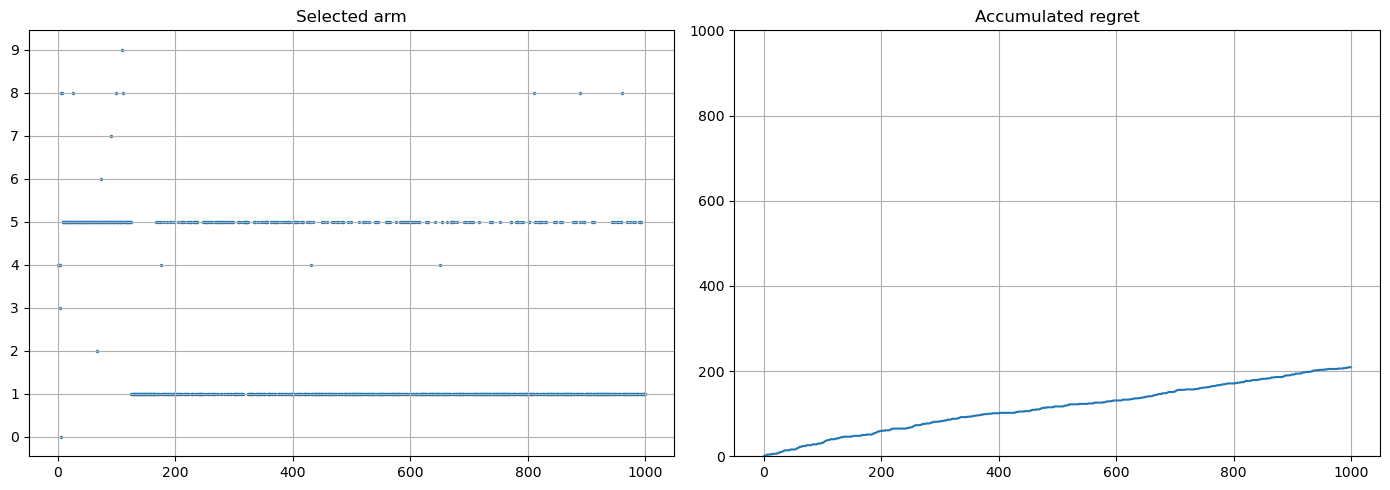

Истинные средние: [0.09 0.84 0.18 0.79 0.33 0.72 0.59 0.51 0.55 0.01]
Найденные оценки: [0.   0.84 0.   0.   0.29 0.73 0.   0.   0.5  0.  ]
Accyracy: 0.791
Оптимальная рука: 1


In [49]:
n_arms = 10
softmaxAgent = Softmax(n_arms, 15)
test(softmaxAgent, n_arms, n_steps=1000)

## UCB

In [43]:
class UCB:
    def __init__(self, num_arms, k=2):
        self.num_arms = num_arms
        self.k = k
        self.Q = np.array([0.9] * num_arms)
        # self.N = np.zeros(num_arms)
        self.N = np.array([1] * num_arms)
        self.t = 1
    
    def action(self, step):        
        ucb = self.Q + np.sqrt(self.k * np.log(self.t) / self.N)
        return np.argmax(ucb)
    
    def step(self, arm, reward):
        self.t += 1
        self.N[arm] += 1
        self.Q[arm] += (reward[arm] - self.Q[arm]) / self.N[arm]

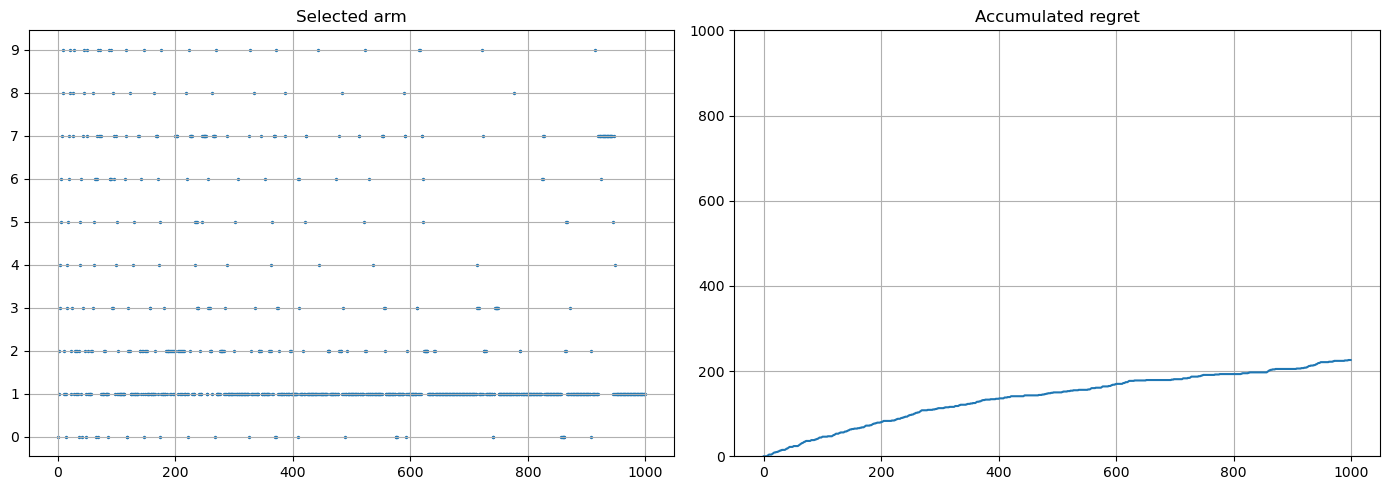

Истинные средние: [0.35 0.92 0.71 0.43 0.07 0.28 0.28 0.56 0.12 0.17]
Найденные оценки: [0.39 0.91 0.68 0.44 0.06 0.2  0.3  0.64 0.12 0.26]
Accyracy: 0.774
Оптимальная рука: 1


In [52]:
n_arms = 10
k = 2
ucbAgent = UCB(n_arms, k)
test(ucbAgent, n_arms, 1000)

## Tompson

In [54]:
class ThompsonSampling:
    def __init__(self, n_arms, alpha=1.0, beta_param=1.0):
        self.n_arms = n_arms
        self.alpha = np.ones(n_arms) * alpha
        self.beta = np.ones(n_arms) * beta_param
        self.Q = [] #заглужка для test

    def action(self, step):   
        samples = [np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.n_arms)]
        return np.argmax(samples)

    def step(self, arm, reward):
        self.alpha[arm] += reward[arm]
        self.beta[arm] = max(1.0, self.beta[arm] + (1 - reward[arm]))

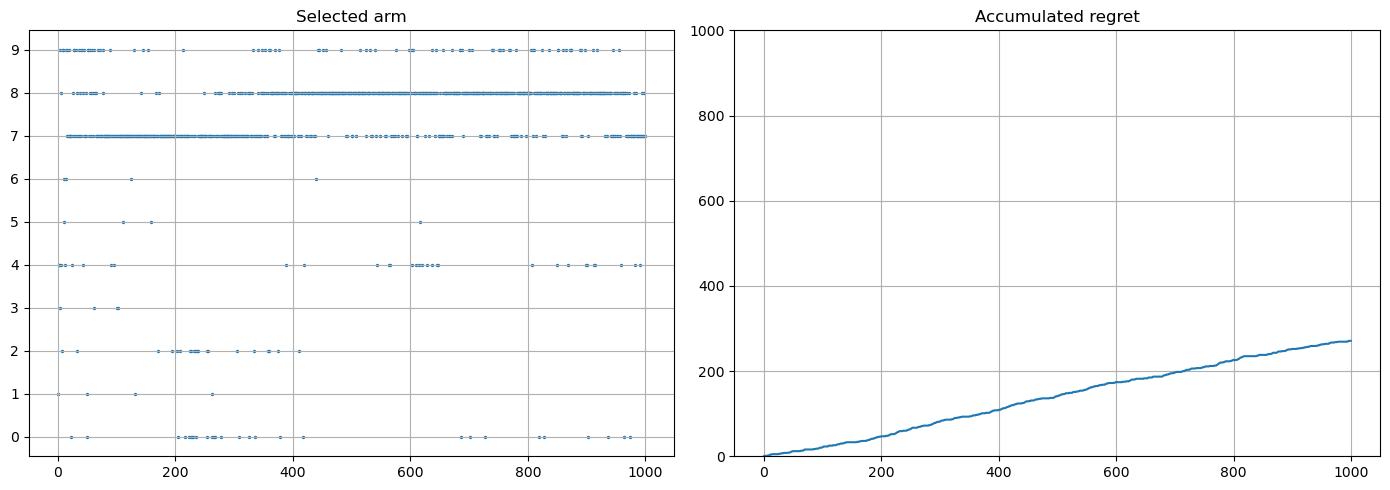

Истинные средние: [0.7  0.15 0.68 0.43 0.8  0.   0.34 0.74 0.74 0.76]
Найденные оценки: []
Accyracy: 0.729
Оптимальная рука: 4


In [60]:
n_arms = 10
ThompsonSamplingAgent = ThompsonSampling(n_arms)
test(ThompsonSamplingAgent, n_arms, n_steps=1000)

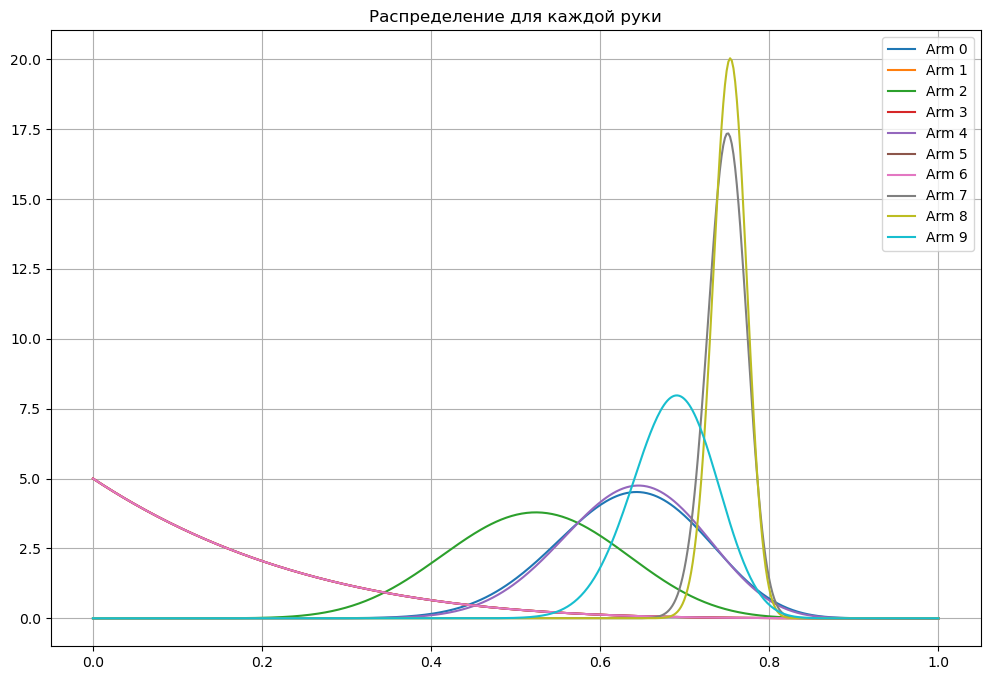

In [62]:
def plot_distributions(agent):
    x = np.linspace(0, 1, 500)
    plt.figure(figsize=(12, 8))
    for i in range(agent.n_arms):
        y = beta.pdf(x, agent.alpha[i], agent.beta[i])
        plt.plot(x, y, label=f'Arm {i}')
    plt.legend()
    plt.grid(True)
    plt.title("Распределение для каждой руки")
    plt.show()

plot_distributions(ThompsonSamplingAgent)